In [1]:
import os
import dask.array as da
import networkx as nx
import numpy as np
import zarr
from epynet import Network

import sys
sys.path.insert(0, os.path.join('..', 'utils'))
from graph_utils import get_nx_graph
from DataReader import DataReader

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
wds_id = 'anytown'

In [3]:
path_to_data = os.path.join('..', 'data', 'db_'+wds_id+'_doe_pumpfed_1')
path_to_wds = os.path.join('..', 'water_networks', wds_id+'.inp')

# Loading data
### Loading graph

In [4]:
wds = Network(path_to_wds)
G_unweighted = get_nx_graph(wds, mode='binary')
L_unweighted = da.array(nx.linalg.laplacianmatrix.laplacian_matrix(G_unweighted).todense())
L_unweighted_normalized = da.array(nx.linalg.laplacianmatrix.normalized_laplacian_matrix(G_unweighted).todense())
G_weighted = get_nx_graph(wds, mode='weighted')
L_weighted = da.array(nx.linalg.laplacianmatrix.laplacian_matrix(G_weighted).todense())
L_weighted_normalized = da.array(nx.linalg.laplacianmatrix.normalized_laplacian_matrix(G_weighted).todense())

### Loading signal

In [5]:
# Complete data
store = zarr.open(path_to_data, mode='r')
X = da.from_zarr(store['trn/junc_heads']).T

# Parted data: observed/unobserved
reader = DataReader(path_to_data, n_junc=len(wds.junctions.uid), obsrat=.2, seed=None)
trn_x_complete, bias_x, scale_x = reader.read_data(
    dataset = 'trn',
    varname = 'junc_heads',
    rescale = 'standardize',
    cover = False
)
trn_x_sparse, bias_x, scale_x = reader.read_data(
    dataset = 'trn',
    varname = 'junc_heads',
    rescale = 'standardize',
    cover = True
)

In [6]:
L_unweighted

dask.array<array, shape=(22, 22), dtype=float64, chunksize=(22, 22), chunktype=numpy.matrix>

In [7]:
L_weighted

dask.array<array, shape=(22, 22), dtype=float64, chunksize=(22, 22), chunktype=numpy.matrix>

In [8]:
X

dask.array<transpose, shape=(22, 600), dtype=float32, chunksize=(22, 600), chunktype=numpy.ndarray>

# Graph signal processing
### Smoothness

In [9]:
smoothness_unweighted = da.dot(X.T, da.dot(L_unweighted, X)).trace()
smoothness_weighted = da.dot(X.T, da.dot(L_weighted, X)).trace()

In [10]:
print('Smoothness with unweighted Laplacian: {:.0f}.'.format(smoothness_unweighted.compute()))
print('Smoothness with weighted Laplacian: {:.0f}.'.format(smoothness_weighted.compute()))

Smoothness with unweighted Laplacian: 13191738.
Smoothness with weighted Laplacian: 2499442.


### Spectrum

In [11]:
eigvals_weighted = np.linalg.eigvals(L_weighted_normalized.compute()).real
eigvals_unweighted = np.linalg.eigvals(L_unweighted_normalized.compute()).real

<BarContainer object of 22 artists>

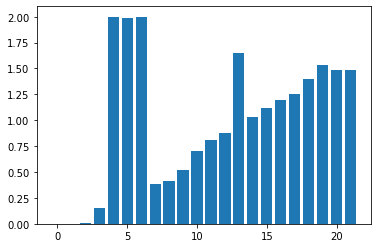

In [12]:
plt.bar(np.arange(len(eigvals_weighted)), eigvals_weighted)

<BarContainer object of 22 artists>

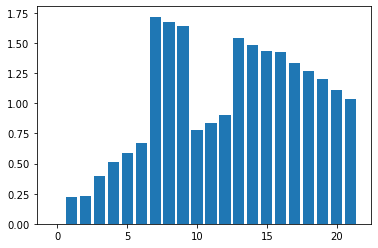

In [13]:
plt.bar(np.arange(len(eigvals_weighted)), eigvals_unweighted)